In [149]:
ts_files = [
    'vm_1_VmgiCwYcPy.csv',
    'vm_2_rr2y46iWRI.csv',
    'vm_3_Ch2tshNe8X.csv',
    'vm_5_FXoWmAfKug.csv',
    'vm_8_gesjL49nFh.csv',
    'vm_12_aa1PrVE9ie.csv',
    'vm_14_XpTL07_3it.csv',
    'vm_15_PNj1J6v0YJ.csv',
    'vm_17_YDo5PVK_75.csv',
    'vm_19_GF6t1yYrx3.csv',
    'vm_20_N0gBVBQviQ.csv',
    'vm_21_gQI5vMY9+5.csv',
    'vm_22_l93uKkSTv8.csv',
    'vm_23_KxsOjS16uU.csv',
    'vm_25_bImCpIMf2H.csv',
    'vm_26_mY+fWVBQe0.csv'
]

In [150]:
#base_path = '/content/drive/MyDrive/MS/dataset/singlets/'
#data_path = base_path + ts_files[2]

base_path = 'https://raw.githubusercontent.com/gags13/datasets/main/'
data_path = base_path + ts_files[8]

In [151]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

In [152]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [153]:
ts_df = pd.read_csv(data_path, index_col=False, delimiter=',')
ts_df.drop(['Unnamed: 0'],axis=1, inplace=True)
ts_df.head()

,timestamp,vm_id,min_cpu,max_cpu,avg_cpu
0,84900,YDo5PVK/75LT5zQJyFNafQ81zT5a5FDeCK/dhRRaVWU2GJ...,0.132371,4.187134,0.444639
1,85200,YDo5PVK/75LT5zQJyFNafQ81zT5a5FDeCK/dhRRaVWU2GJ...,0.197401,0.446355,0.296366
2,85500,YDo5PVK/75LT5zQJyFNafQ81zT5a5FDeCK/dhRRaVWU2GJ...,0.217408,21.254750,3.738477
3,85800,YDo5PVK/75LT5zQJyFNafQ81zT5a5FDeCK/dhRRaVWU2GJ...,0.669001,1.522518,1.004140
4,86100,YDo5PVK/75LT5zQJyFNafQ81zT5a5FDeCK/dhRRaVWU2GJ...,0.723263,98.073587,10.090294


In [154]:
vm_id = ts_df.vm_id.values[0]
print("VM ID :", vm_id)

VM ID : YDo5PVK/75LT5zQJyFNafQ81zT5a5FDeCK/dhRRaVWU2GJwHT+lW0yDaf2sNHqLD


In [155]:
ts_df.drop(['vm_id'],axis=1, inplace=True)
ts_df.head()

,timestamp,min_cpu,max_cpu,avg_cpu
0,84900,0.132371,4.187134,0.444639
1,85200,0.197401,0.446355,0.296366
2,85500,0.217408,21.254750,3.738477
3,85800,0.669001,1.522518,1.004140
4,86100,0.723263,98.073587,10.090294


In [156]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU

In [157]:
tf.random.set_seed(1310)

In [158]:
ts_df['timestamp'] = ts_df['timestamp']/300
ts_df['timestamp'] = ts_df['timestamp'].astype('int')
ts_df.head()

,timestamp,min_cpu,max_cpu,avg_cpu
0,283,0.132371,4.187134,0.444639
1,284,0.197401,0.446355,0.296366
2,285,0.217408,21.254750,3.738477
3,286,0.669001,1.522518,1.004140
4,287,0.723263,98.073587,10.090294


In [159]:
def timeseries (x_axis, y_axis, y_label):
    plt.figure(figsize = (20, 6))
    plt.plot(x_axis, y_axis, color ='blue')
    plt.xlabel('time', {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})

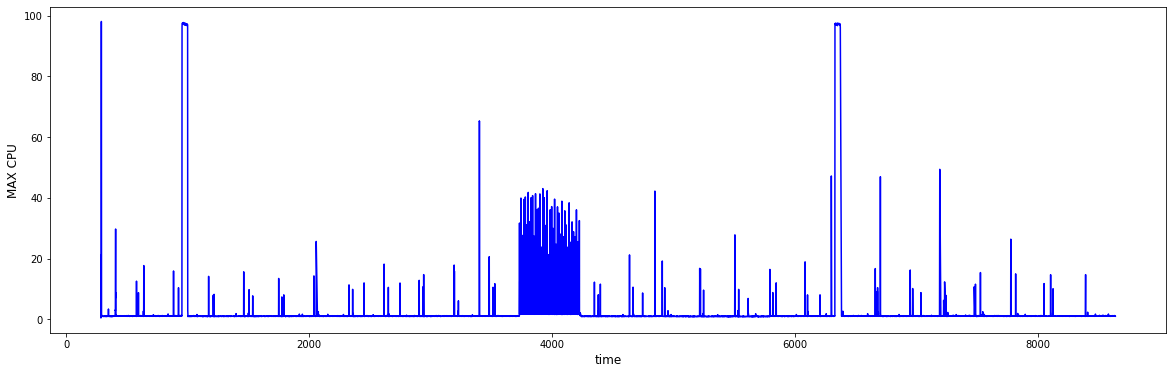

In [160]:
timeseries (ts_df['timestamp'], ts_df['max_cpu'], 'MAX CPU')

In [161]:
df_max = ts_df.drop(['min_cpu', 'avg_cpu'], axis=1)
df_max = df_max.set_index('timestamp')
df_max.head()

,max_cpu
timestamp,
283,4.187134
284,0.446355
285,21.254750
286,1.522518
287,98.073587


In [162]:
# Split train data and test data
train_size = int(len(df_max)*0.7)

train_data = df_max.iloc[:train_size]
test_data = df_max.iloc[train_size:]

In [163]:
test_data.shape

(2480, 1)

In [164]:
def df_input_to_X_y(df, window_size=864):
  df_to_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_to_np)-window_size):
    row = [[a] for a in df_to_np[i:i+window_size]]
    X.append(row)
    label = df_to_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [165]:
WINDOW_SIZE = 864
X_train, y_train = df_input_to_X_y(train_data,WINDOW_SIZE)
X_test, y_test = df_input_to_X_y(test_data,WINDOW_SIZE)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (4922, 864, 1, 1)
y_train.shape:  (4922, 1)
X_test.shape:  (1616, 864, 1, 1)
y_test.shape:  (1616, 1)


In [166]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse', metrics=["mae", "acc"])
    return model
model_gru = create_gru(64)

In [167]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 15,  
                        validation_split = 0.3,
                        batch_size = 8, shuffle = False)
    return history
history_gru = fit_model(model_gru)

Epoch 1/15
431/431 [==============================] - 29s 60ms/step - loss: 17.3022 - mae: 1.1507 - acc: 0.0000e+00 - val_loss: 3.6065 - val_mae: 0.4109 - val_acc: 0.0000e+00
Epoch 2/15
431/431 [==============================] - 24s 56ms/step - loss: 17.3605 - mae: 1.1360 - acc: 0.0000e+00 - val_loss: 3.7063 - val_mae: 0.3302 - val_acc: 0.0000e+00
Epoch 3/15
431/431 [==============================] - 25s 58ms/step - loss: 15.8140 - mae: 1.0560 - acc: 0.0000e+00 - val_loss: 3.8963 - val_mae: 0.4544 - val_acc: 0.0000e+00
Epoch 4/15
431/431 [==============================] - 25s 58ms/step - loss: 17.6198 - mae: 1.2903 - acc: 0.0000e+00 - val_loss: 3.7972 - val_mae: 0.3388 - val_acc: 0.0000e+00
Epoch 5/15
431/431 [==============================] - 25s 58ms/step - loss: 17.0744 - mae: 1.1983 - acc: 0.0000e+00 - val_loss: 3.6607 - val_mae: 0.3197 - val_acc: 0.0000e+00
Epoch 6/15
431/431 [==============================] - 24s 56ms/step - loss: 16.3787 - mae: 1.1209 - acc: 0.0000e+00 - val_los

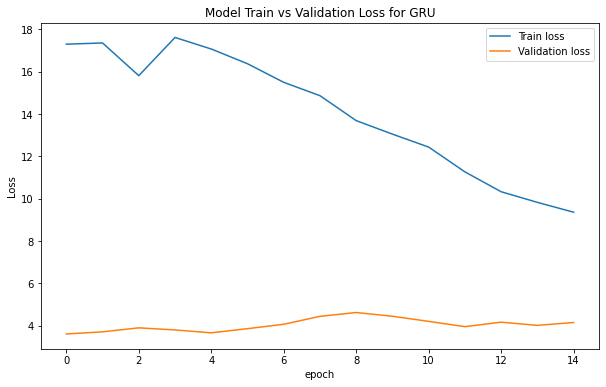

In [168]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')

In [169]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    return prediction
prediction_gru = prediction(model_gru)

51/51 [==============================] - 2s 34ms/step


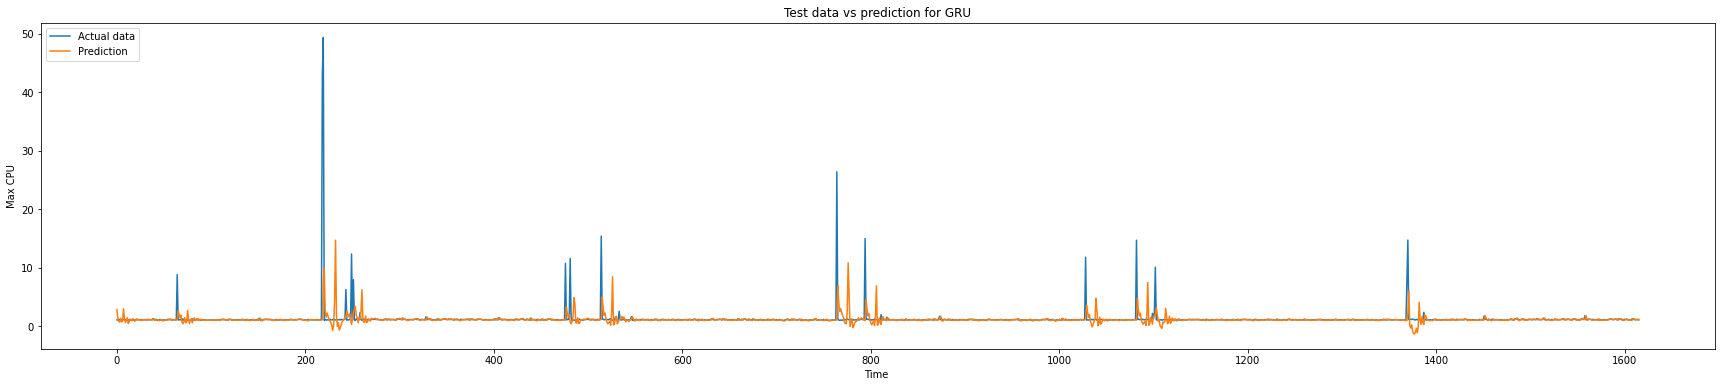

In [170]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(30, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Actual data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time ')
    plt.ylabel('Max CPU')
 
plot_future(prediction_gru, 'GRU', y_test)

In [171]:
predicted_max_list = []
for looped in prediction_gru:
  predicted_max_list.append(looped[0])
len(predicted_max_list)

1616

In [172]:
analysis_df = pd.DataFrame()
analysis_df = test_data.tail(prediction_gru.shape[0])
analysis_df['pred_max_cpu'] = predicted_max_list
analysis_df.shape

(1616, 2)

In [173]:
max_allowed_jump = 1.5
peak_quantile = 0.9
prev_val = analysis_df['pred_max_cpu'].quantile(q=peak_quantile)
i = 0.91
while i < 1:
  curr_val = analysis_df['pred_max_cpu'].quantile(q=i)
  if (curr_val - (prev_val*max_allowed_jump)) > 0.0:
    break
  peak_quantile = i
  prev_val = curr_val
  i = i + 0.01

peak_val = analysis_df['pred_max_cpu'].quantile(q=peak_quantile)
print(peak_val)

2.7035624980926536


In [174]:
analysis_df.insert(0, 'id', range(1, 1 + len(analysis_df)))
analysis_df.head()

,id,max_cpu,pred_max_cpu
timestamp,,,
6973,1,1.043323,2.824308
6974,2,1.049002,1.257207
6975,3,1.144657,0.772600
6976,4,1.061171,0.656847
6977,5,1.189993,1.327303


In [175]:
analysis_df[analysis_df['pred_max_cpu'] > peak_val].id.values

array([   1,    8,  220,  221,  222,  232,  233,  253,  254,  261,  478,
        486,  487,  516,  517,  527,  766,  767,  769,  777,  778,  796,
        797,  807, 1030, 1040, 1084, 1085, 1095, 1104, 1114, 1372, 1383])

In [176]:
high_cpu_values = set(analysis_df[analysis_df['pred_max_cpu'] > peak_val].id.values)
len(high_cpu_values)

33

In [177]:
high_band_cpu = []
for val in high_cpu_values:
  high_band_cpu.extend(list(range(val-5,val+5)))

In [178]:
print(len(high_band_cpu))
print(len(set(high_band_cpu)))

330
221


In [179]:
high_cpu_values = high_cpu_values.union(set(high_band_cpu))
len(high_cpu_values)

221

In [180]:
analysis_df['highcpu'] = analysis_df['id'].map(lambda p : 100 if p in high_cpu_values else 50)
analysis_df[analysis_df['highcpu'] == 100].shape

(216, 4)

Text(0, 0.5, 'Max CPU')

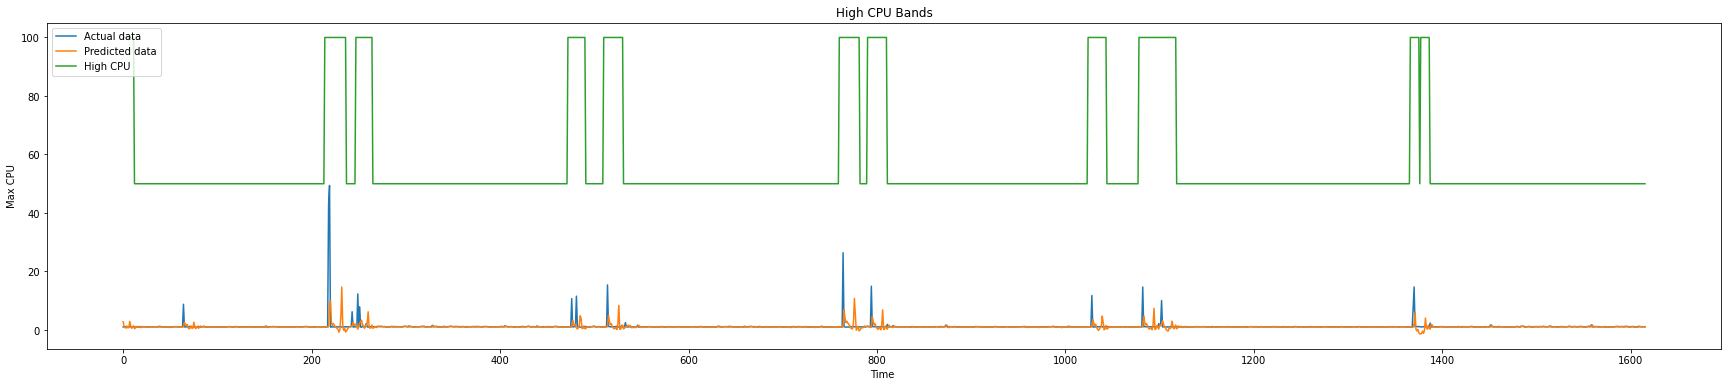

In [181]:
plt.figure(figsize=(30, 6))
range_future = len(analysis_df)
plt.plot(np.arange(range_future), np.array(analysis_df.max_cpu), 
         label='Actual data')
plt.plot(np.arange(range_future), 
         np.array(analysis_df.pred_max_cpu),label='Predicted data')
plt.plot(np.arange(range_future), 
         np.array(analysis_df.highcpu),label='High CPU')
plt.title('High CPU Bands')
plt.legend(loc='upper left')
plt.xlabel('Time ')
plt.ylabel('Max CPU')

In [182]:
data_path = 'https://raw.githubusercontent.com/gags13/datasets/main/final_filtered.csv'

vm_dataframe = pd.read_csv(data_path, index_col=False, delimiter=',')
vm_dataframe.drop(['Unnamed: 0'],axis=1, inplace=True)
vm_dataframe.head()

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour,target,delmaxavg,delmaxp95,delp95avg,kmeans,gm,p95avgcpuslope
0,trjCc/lisNnKRnpFtPMmULgw1gUoiymSCshiGZfLY/Oil4...,9j4lLAdcydRsC+LhAQG/IS6Q15Z+tw3IYiCwH6QuxxtuQ1...,amCh31pwRrNqxYhYZMQ9kTaBv6Nsj9KELkMwZXIujmvpbm...,0,2591400,96.715705,0.938933,0.863622,Delay-insensitive,2,2,719.833333,1439.666667,1,95.776771,95.852083,-0.075311,0,1,0.919790
1,RVfel1jVo2UTjdHeqMgqJcVcfBUG/V9mV6Un47p8vGHiFj...,NM+rYlOuvfObftjnvrHy7hUorr5ulWm8UgTM9A1SZniRTv...,tGInpwc5Wi0Tq15xunBKLtsbC6Bxk5LP2e+NIsoDe/D3jg...,0,2589000,98.226568,2.410055,2.297678,Delay-insensitive,2,8,719.166667,1438.333333,1,95.816514,95.928891,-0.112377,0,2,0.953372
2,mY+fWVBQe0tTfdVMO/2Ea9AAjDyN2ndi/40U59iUNxiTRu...,8mYUop47Ih3Ka0m8+fxnNmM1rUjlJ9vDkclgoBJViVmWPr...,fIRf+CYG8jmlnysPUgzCuo7L/D1tV9jirr4FaJCQtaI7/n...,28800,2591400,97.194277,2.076477,1.938042,Delay-insensitive,4,32,711.833333,2847.333333,1,95.117800,95.256236,-0.138435,0,1,0.933332
3,N0gBVBQviQ4n/jyolzXWac39GOcL3596Re7d2N7RpmffGF...,8mYUop47Ih3Ka0m8+fxnNmM1rUjlJ9vDkclgoBJViVmWPr...,fIRf+CYG8jmlnysPUgzCuo7L/D1tV9jirr4FaJCQtaI7/n...,28500,2591400,98.838522,2.479152,2.367730,Delay-insensitive,4,32,711.916667,2847.666667,1,96.359369,96.470792,-0.111423,0,1,0.955056
4,4Cka/a5H763ZPaDuuNo6MhnfKQ56hvTrTxPgWmcJyh2ItB...,HzLK24LbYXd1kU9jw99gYFREpnAkKefq7MKwAxhEwzct60...,wggQWvknTcqrfDqxcQGGT40iu8/aEgjBj5i6e3bu9qtUc8...,0,2591400,99.278745,0.895093,0.716898,Delay-insensitive,2,2,719.833333,1439.666667,1,98.383652,98.561847,-0.178195,0,1,0.800920


In [183]:
core_hour_saved_per_core = (5*len(analysis_df[analysis_df['highcpu'] == 50])/60)/2
total_core_hour_per_core = 5*len(analysis_df)/60
core_count = vm_dataframe[vm_dataframe['vmid'] == vm_id].vmcorecountbucket.values[0]

In [184]:
print("TOTAL CPU CORE HOUR (CURRENT)", total_core_hour_per_core*core_count)
print("TOTAL CPU CORE HOUR (PROPOSED)", (total_core_hour_per_core*core_count) - (core_hour_saved_per_core*core_count))

TOTAL CPU CORE HOUR (CURRENT) 538.6666666666666
TOTAL CPU CORE HOUR (PROPOSED) 305.33333333333326


In [185]:
print("WASTED CPU %",100*(((total_core_hour_per_core*core_count) - (core_hour_saved_per_core*core_count))/(total_core_hour_per_core*core_count)))

WASTED CPU % 56.683168316831676
